In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

import livelossplot.keras
class PlotLossesCallback(livelossplot.keras.PlotLossesCallback):
    def on_train_batch_begin(self, a, b): pass
    def on_train_batch_end(self, a, b): pass
    def on_test_begin(self, a): pass
    def on_test_end(self, a): pass
    def on_test_batch_begin(self, a, b): pass
    def on_test_batch_end(self, a, b): pass

    
class PlotRelevanceCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_size_inches(13, 3)
        w = self.model.layers[0].weights
        ax1.bar(range(0,4), w[0][0:4])
        labels = ['Ip','NS','Vt','F']
        plt.sca(ax1)
        plt.xticks(range(0,4), labels, fontsize=10)
        ax2.bar(range(7,17), w[0][4:14])
        plt.sca(ax2)
        plt.xticks(range(7,17), fontsize=10)        
        ax3.bar(range(7,17), w[0][14:24])
        plt.sca(ax3)
        plt.xticks(range(7,17), fontsize=10)       


# ipysh.Bootstrap_support.debug()

# TEST QSH


In [3]:
qsh = Dataset_QSH.Dataset_QSH()
import os
file = ipysh.abs_builddir+'/te_db_r15_clean_shuffle.npy'
try: qsh.load(file)
except: raise FileNotFoundError

# qsh.shuffle()
qsh.dim = None
qsh.set_null(np.nan)
qsh.set_normal_positive(['prel','te','tbordo','tcentro', 'Ip','NS','VT','F','absBr_rm','argBr_rm','absBr_rs','argBr_rs']) 
print("QSH rebalanced 15 points size: ", len(qsh))


QSH rebalanced 15 points size:  47567


In [4]:
def _map(xy,p,Br):
    pBr = tf.concat([p,Br], axis=0)
    return pBr,xy

ds = qsh.tf_tuple_compose(['prel~te:15','Ip~NS~VT~F','absBr_rm~argBr_rm~absBr_rs~argBr_rs']).map(lambda x,y,br: _map(x,y,br) )
[x for x in ds.shuffle(100).batch(1).take(1)][0]

W0906 14:42:52.772232 140087090325312 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:504: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(<tf.Tensor: id=56, shape=(1, 44), dtype=float32, numpy=
 array([[8.7526995e-01, 4.9680895e-01, 9.8512733e-01, 7.3412305e-01,
         4.3502867e-01, 5.3683680e-02, 4.9953021e-02, 6.2115386e-02,
         9.8330975e-02, 6.0307477e-02, 9.5357247e-02, 3.7674870e-02,
         7.4591286e-02, 5.5622768e-02, 5.1012702e-02, 1.7239663e-01,
         8.4336832e-02, 6.5718717e-03, 9.7543138e-01, 6.5664470e-01,
         4.7113231e-01, 1.9222546e-01, 9.6547389e-01, 7.0221102e-01,
         1.3398255e-02, 8.2531950e-04, 1.6459491e-03, 9.8678679e-04,
         1.1365159e-03, 8.6481258e-04, 6.8377139e-04, 6.9285580e-04,
         7.1033306e-04, 7.9047063e-04, 1.1165841e-02, 7.6193377e-02,
         5.5206433e-02, 9.6330190e-01, 9.4763947e-01, 7.2920549e-01,
         5.3576487e-01, 2.2111243e-01, 9.9739903e-01, 7.0583832e-01]],
       dtype=float32)>, <tf.Tensor: id=57, shape=(1, 30), dtype=float32, numpy=
 array([[0.02686268, 0.09764964, 0.14211765, 0.19789246, 0.26058832,
         0.33119917, 0.40805736, 

In [5]:
vae = models.AEFIT5.AEFIT5(latent_dim=6, feature_dim=30, dprate=0.1, beta=0., scale=2, geometry=[20,20,10,10])
vae.build(input_shape=vae.inference_net.input_shape)
vae.compile( vae.optimizer, tf.losses.mse )


AEFIT5 a ready:


In [ ]:
dds = ds.map(lambda p,xy: (xy,xy))
vae_history = vae.fit( dds.skip(5000).batch(100, drop_remainder=True), validation_data=dds.take(5000).batch(100), epochs=50)

In [6]:
# vae.save('step12_vae_ls')
vae.load('step12_vae_ls')
# plt.figure('vae_history')
# plt.plot(vae_history.history['loss'])
# plt.plot(vae_history.history['val_loss'])

In [9]:
vae1 = models.AEFIT5.AEFIT5(latent_dim=3, feature_dim=44, dprate=0.1, scale=2, geometry=[20,20,10,10])
vae1.generative_net.trainable = False
gen = vae1.inference_net

AEFIT5 a ready:


In [10]:
Dds = ds.map(lambda p,xy: (p, tf.reshape(vae.encode(tf.reshape(xy,[1,-1]),training=False)[0],[-1])) )
[x for x in Dds.batch(1).take(1)][0]

(<tf.Tensor: id=1604, shape=(1, 44), dtype=float32, numpy=
 array([[9.0212119e-01, 5.3695828e-01, 9.1727191e-01, 7.3195302e-01,
         4.7435814e-01, 5.9198900e-03, 5.8772485e-03, 2.9242661e-02,
         3.1777993e-02, 1.3722557e-02, 4.1746788e-02, 3.5960115e-02,
         1.4477799e-02, 1.4586192e-02, 2.9532781e-01, 5.9849793e-01,
         2.8364006e-01, 9.0192956e-01, 6.4602979e-02, 6.1756039e-01,
         7.1092939e-01, 4.0907342e-02, 3.6262920e-01, 6.4586556e-01,
         1.4940434e-02, 1.7482054e-04, 4.8770773e-04, 4.5972806e-04,
         3.7976884e-04, 4.0374318e-04, 4.6589554e-04, 3.8630475e-04,
         2.0644740e-04, 1.4833955e-04, 2.1594514e-01, 6.9604772e-01,
         2.8233867e-02, 8.5595667e-01, 9.7706079e-01, 6.3353217e-01,
         7.4795914e-01, 2.2909560e-03, 4.7446406e-01, 7.6721263e-01]],
       dtype=float32)>,
 <tf.Tensor: id=1605, shape=(1, 6), dtype=float32, numpy=
 array([[ 0.06841117, -0.02159064,  0.18599351,  0.00287939,  0.13772218,
         -0.18347163]], 

In [11]:
# TRAIN MODEL
rel = gen.layers[0]
rel.rate = 0.
gen.compile( tf.optimizers.Adam(1e-3), tf.losses.mse )

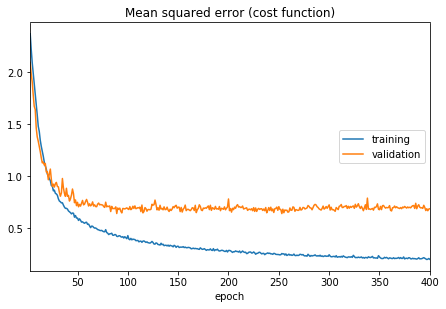

Mean squared error (cost function):
training   (min:    0.199, max:    3.043, cur:    0.201)
validation (min:    0.641, max:    2.585, cur:    0.687)
446/446 [==============================] - 85s 192ms/step - loss: 0.2008 - val_loss: 0.6872


In [118]:
fit = lambda: gen.fit( Dds.skip(3000).batch(100), validation_data=Dds.take(3000).batch(100), epochs=400,
                      callbacks=[PlotLossesCallback()], shuffle=False )
models.base.fn_thread(gen, fit).control_panel()

In [ ]:
# TODO:
# save this image as:  STEP12_7_pBr2SXR_rm-rs_absarg_training_mse.png

In [7]:
gen.layers[1].weights

NameError: name 'gen' is not defined

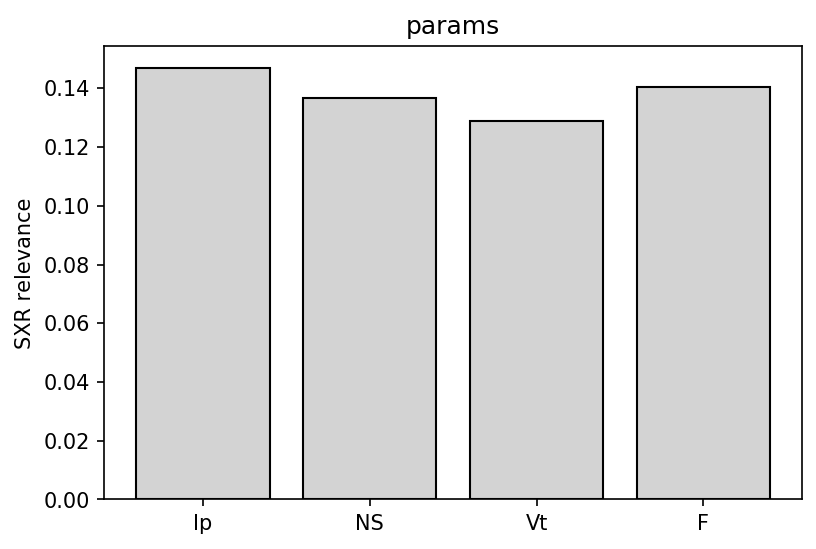

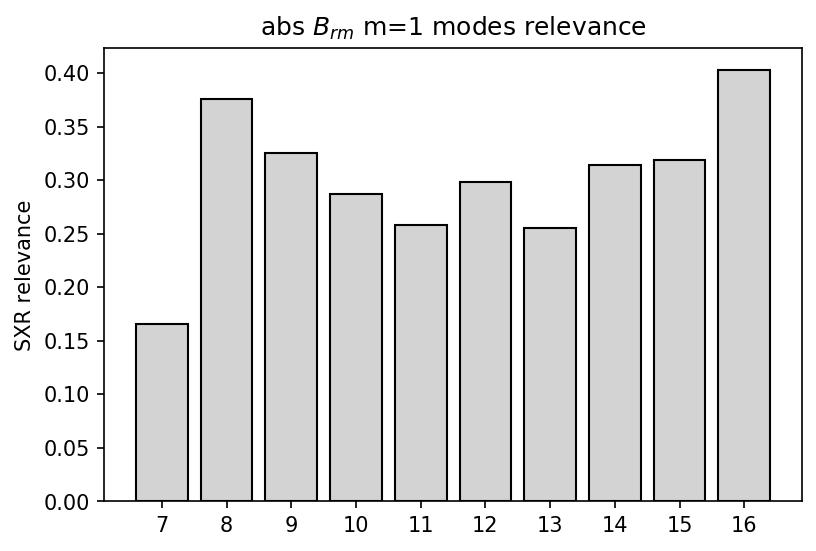

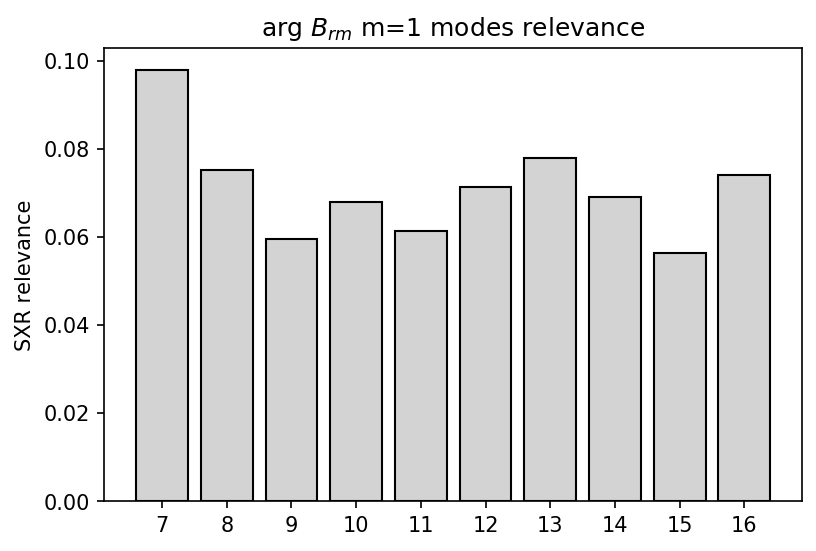

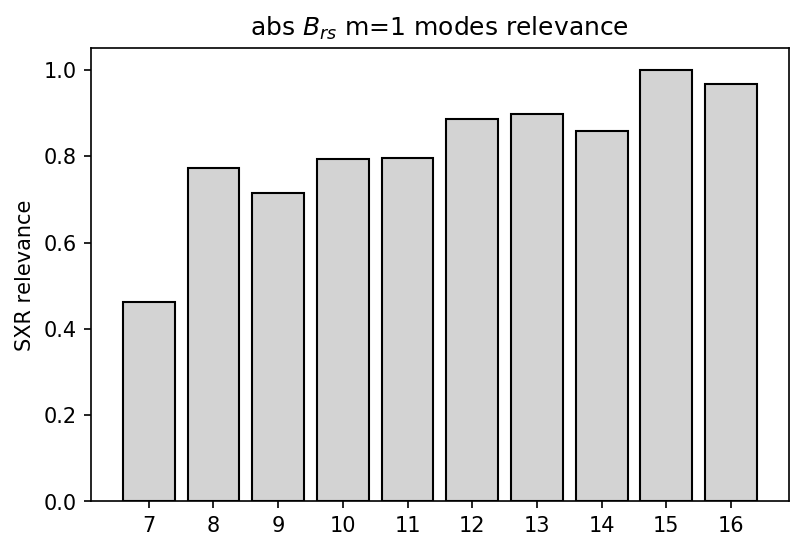

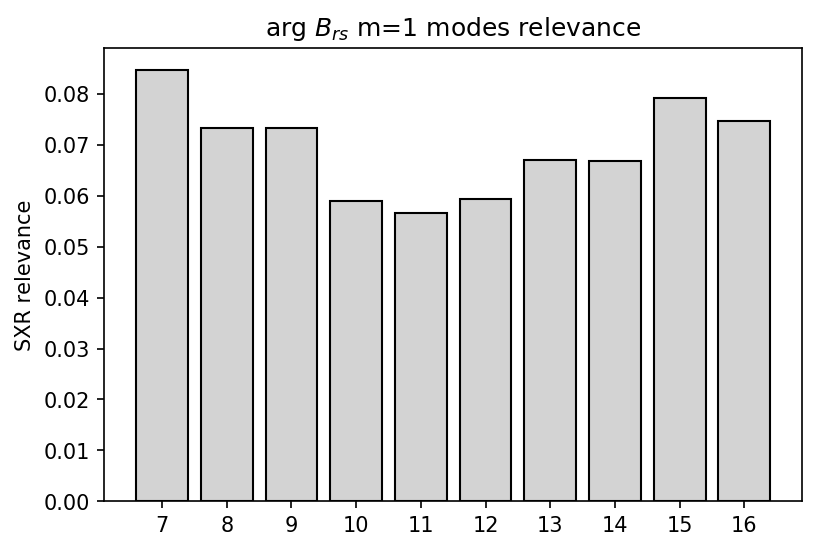

In [388]:
index = qsh[0].n
w = gen.layers[1].weights
%matplotlib inline

def plot_bar_x(index, w, title, w2=None):
    # this is for plotting purpose
    fig = plt.figure(title)
    fig.set_dpi(150)
    plt.bar(index, w, color='lightgrey', edgecolor='black')    
    plt.ylabel('SXR relevance', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    plt.show()

p,abs_Brm,arg_Brm,abs_Brs,arg_Brs = w[0][0:4],w[0][4:14], w[0][14:24], w[0][24:34], w[0][34:44]
plot_bar_x(['Ip','NS','Vt','F'], p, 'params')
plot_bar_x(index, abs_Brm, 'abs $B_{rm}$ m=1 modes relevance')
plot_bar_x(index, arg_Brm, 'arg $B_{rm}$ m=1 modes relevance')
plot_bar_x(index, abs_Brs, 'abs $B_{rs}$ m=1 modes relevance')
plot_bar_x(index, arg_Brs, 'arg $B_{rs}$ m=1 modes relevance')


In [12]:
# vae1.save('step12.7_p2ls_BrmBrs_abs-arg')
vae1.load('step12.7_p2ls_BrmBrs_abs-arg')

In [97]:
pos = 0

245


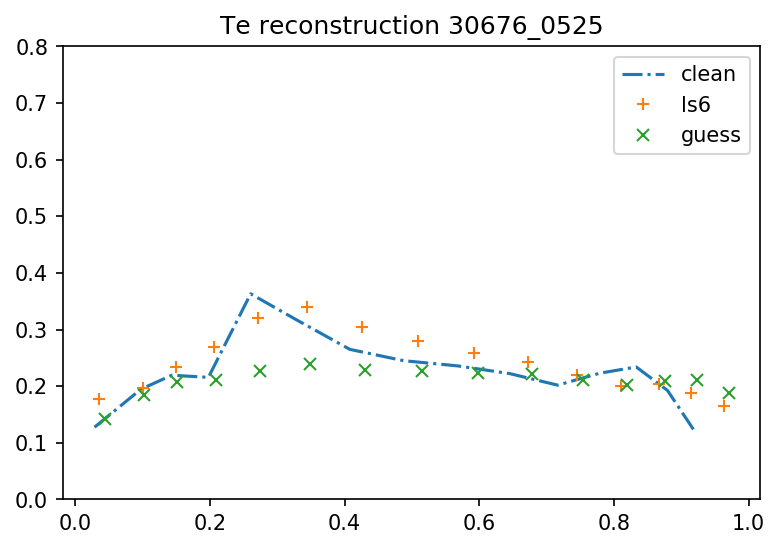

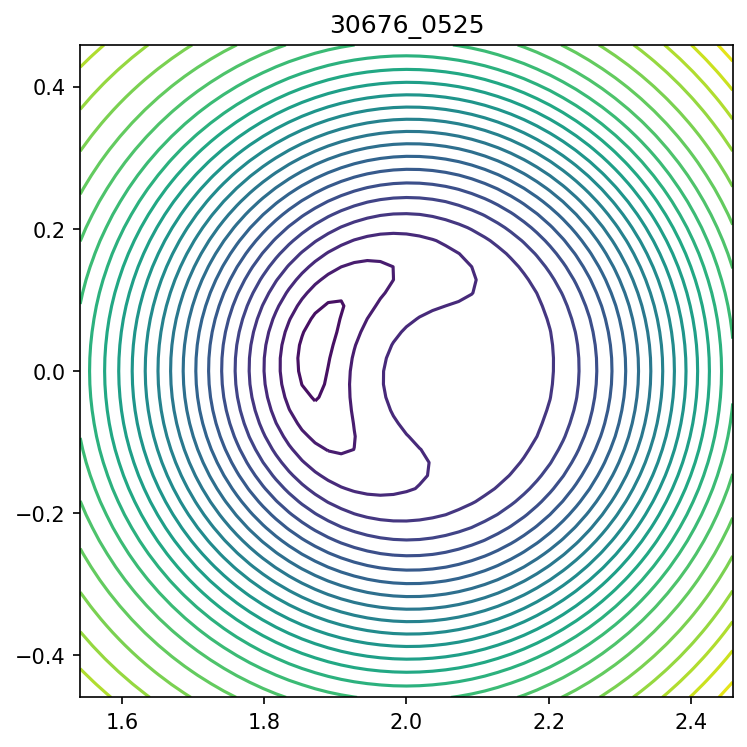

In [274]:
print(pos)

d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
path = '/home/andrea/Documents/phd/Thesis/img/STEP12/STEP12_7'


def plot_tf(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,h, label=name)
    ax.legend()

def plot(xy, name=None, h='.'):  
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,0.8)
    plt.plot(xy, h, label=name)
    ax.legend()
    
p  = d_pos[0]
xy = d_pos[1]

fig = plt.figure('plot')
# plt.text(0.05,0.7, '$I_p = %.2f$'%qsh[pos]['Ip'] )
ax = plt.gca()
ax.set_title( 'Te reconstruction '+qsh[pos].label.decode("utf-8") )

XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot_tf(xy, 'clean','-.')
plot_tf(XY_vae, 'ls6','+')
plot_tf(XY, 'guess','x')
# plot(qsh[pos]['tcentro'], '$T_c$')
qsh[pos].plot_countour()

fig = plt.figure('plot')
fig.savefig( path+'/Te_rec_'+str(pos)+'.png')
# fig = plt.figure('Flux')
# fig.savefig(path+'/Te_Flux_'+str(pos)+'.png')



pos += 1

In [ ]:
plt.figure('Ip_error')
